In [ ]:
# The task is to write a count of the number of first elements (not including this element itself)
# in a fixed-size sequence consisting of the characters A, B, C

# [A, B, B, C] ->  { A:0, B: 1, C: 0 }
# [C, B, B, B, A, B, C] ->  { C: 0, B: 2: B: 2 }

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import random

## SEED

In [ ]:
torch.use_deterministic_algorithms(True)
SEED = 1 # try to 42

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## CONSTANTS

In [ ]:
vocabular = ["A", "B", "C", "D", "-"]
query_vocabular = ["CNTR_FIRST", "CNTR_SECOND", "CNTR_THIRD"]

S = 20
E_x = len(vocabular)

L = len(query_vocabular)
E_y = S + 1

E_q = len(query_vocabular)

E_hidden = 64
SQRT_E_k = np.sqrt(E_hidden)

BATCH_SIZE = 100

GRAD_CLIP = 1.0

## DATA

In [ ]:
id_to_char = { i: symbol for i, symbol in enumerate(vocabular)}
char_to_id = { symbol: i for i, symbol in id_to_char.items() }

id_to_query = { i: q for i, q in enumerate(query_vocabular)}
query_to_id = { q: i for i, q in id_to_query.items() }

def get_seq():
  seq = np.random.randint(low=0, high=len(vocabular), size=S)
  return seq

def str_seq(sequence):
  return [id_to_char[i] for i in sequence]

def get_counter(sequence):
  counter = [0 for i in range(len(vocabular))]
  for seq_id in sequence:
    counter[seq_id] += 1

  first_counters = []
  for seq_id in sequence:
    if id_to_char[seq_id] != "-":
      first_counters.append(counter[seq_id] - 1)
      if len(first_counters) >= len(query_vocabular):
        break

  return np.array(first_counters)

def str_counter(counter):
  return counter

In [ ]:
seq = get_seq()
counter = get_counter(seq)

print("seq:", seq)
print("counter:", counter)
print("====or====")
print("seq:", str_seq(seq))
print("counter:", str_counter(counter))

seq: [3 4 0 1 3 0 0 1 4 4 1 2 4 2 4 3 4 2 4 2]
counter: [2 2 2]
====or====
seq: ['D', '-', 'A', 'B', 'D', 'A', 'A', 'B', '-', '-', 'B', 'C', '-', 'C', '-', 'D', '-', 'C', '-', 'C']
counter: [2 2 2]


## DATASET

In [ ]:
class SequenceCounterDataset(torch.utils.data.Dataset):
  def __init__(self, N):
      self.N = N

  def __getitem__(self, index):
    x = get_seq()
    y = get_counter(x)

    x = torch.Tensor(x).long()
    y = torch.Tensor(y).long()

    return x, y

  def __len__(self):
    return self.N

## MODEL_V2_POS_ENC

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self):
    super(EncoderBlock, self).__init__()
    self.self_att = torch.nn.MultiheadAttention(
        embed_dim = E_hidden,
        num_heads = 4,
        batch_first=True
    )
    self.norm_1 = nn.LayerNorm(E_hidden)
    self.dense_1 = nn.Linear(E_hidden, E_hidden)
    self.dense_2 = nn.Linear(E_hidden, E_hidden)
    self.norm_2 = nn.LayerNorm(E_hidden)

  def forward(
      self,
      x, # [N, S, E_hidden]
  ):
    x_tmp, _ = self.self_att(
        query=x,
        key=x,
        value=x
    ) # [N, S, E_hidden]
    x = x + x_tmp # [N, S, E_hidden]
    x = self.norm_1(x) # [N, S, E_hidden]

    x_tmp = self.dense_1(x) # [N, S, E_hidden]
    x_tmp = F.relu(x_tmp) # [N, S, E_hidden]
    x_tmp = self.dense_2(x_tmp) # [N, S, E_hidden]
    x = x + x_tmp # [N, S, E_hidden]
    x = self.norm_2(x) # [N, S, E_hidden]

    return x


class DecoderBlock(nn.Module):
  def __init__(self):
    super(DecoderBlock, self).__init__()
    self.self_att = torch.nn.MultiheadAttention(
        embed_dim = E_hidden,
        num_heads = 4,
        batch_first=True
    )
    self.norm_1 = nn.LayerNorm(E_hidden)

    self.cross_att = torch.nn.MultiheadAttention(
        embed_dim = E_hidden,
        num_heads = 4,
        batch_first=True
    )

    self.dense_1 = nn.Linear(E_hidden, E_hidden)
    self.dense_2 = nn.Linear(E_hidden, E_hidden)

    self.norm_2 = nn.LayerNorm(E_hidden)
    self.norm_3 = nn.LayerNorm(E_hidden)

  def forward(
      self,
      x, # [N, S, E_hidden]
      q  # [N, L, E_hidden]
  ):

    # Pay attention: mixed q1/q2/q3 !
    q_tmp, _ = self.self_att(
        query=q,
        key=q,
        value=q
    ) # [N, L, E_hidden]
    q = q + q_tmp # [N, L, E_hidden]
    q = self.norm_1(q) # [N, L, E_hidden]

    q_tmp, cross_att_weights = self.cross_att(
        query=q,
        key=x,
        value=x
    ) # [N, L, E_hidden]
    q = q + q_tmp # [N, L, E_hidden]
    q = self.norm_2(q) # [N, L, E_hidden]

    q_tmp = self.dense_1(q) # [N, L, E_hidden]
    q_tmp = F.relu(q_tmp) # [N, L, E_hidden]
    q_tmp = self.dense_1(q_tmp) # [N, L, E_hidden]
    q = q + q_tmp # [N, L, E_hidden]

    q = self.norm_2(q) # [N, L, E_hidden]

    return q, cross_att_weights


class AttentionModel_POS_ENC(nn.Module):
  def __init__(self):
    super(AttentionModel_POS_ENC, self).__init__()

    self.x_emb = nn.Embedding(
        num_embeddings=E_x,
        embedding_dim=E_hidden
    )

    self.q_emb = nn.Embedding(
        num_embeddings=E_q,
        embedding_dim=E_hidden
    )

    self.pos_enc_emb = nn.Embedding(
        num_embeddings=S,
        embedding_dim=E_hidden
    )

    self.encoder_1 = EncoderBlock()
    self.encoder_2 = EncoderBlock()

    self.decoder_1 = DecoderBlock()
    self.decoder_2 = DecoderBlock()

    self.final_dense = nn.Linear(E_hidden, E_y)

  def forward(
      self,
      x, # [N, S]
      q  # [N, L]
  ):
    x = self.x_emb(x) # [N, S, E_x]
    q = self.q_emb(q) # [N, L, E_q]

    pos_enc = self.pos_enc_emb(torch.arange(0, x.shape[1]).long()) # [S, E_hidden]
    x = x + pos_enc

    x = self.encoder_1(x) # [S, E_hidden]
    x = self.encoder_2(x) # [S, E_hidden]

    out, cross_att_weights = self.decoder_1(x, q) # out=[N, L, E_hidden]
    out, _ = self.decoder_2(x, out) # out=[N, L, E_hidden]

    out = self.final_dense(out) # [N, L, E_y]

    return out, cross_att_weights


model = AttentionModel_POS_ENC()
seq = torch.Tensor(get_seq()).long().unsqueeze(0) # [1, S]
q = [query_to_id[it] for it in ["CNTR_FIRST", "CNTR_SECOND", "CNTR_THIRD"]] # [L]
q = torch.Tensor(q).long() # [L]
q = q.unsqueeze(dim=0) # [1, L]

out, attention_weights = model(
  x=seq,
  q=q
)
print("out:", out.shape)
print("attention_weights:", attention_weights.shape)

out: torch.Size([1, 3, 21])
attention_weights: torch.Size([1, 3, 20])


## TRAIN LOOP

In [ ]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

train_loader = torch.utils.data.DataLoader(
    SequenceCounterDataset(2000 * 100),
    shuffle=True,
    sampler=None,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    drop_last=True,
)

model = AttentionModel_POS_ENC()

q = [query_to_id[it] for it in ["CNTR_FIRST", "CNTR_SECOND", "CNTR_THIRD"]]
q = torch.Tensor(q).long() # [L]
q = q.unsqueeze(dim=0) # [1, L]
q = q.repeat((BATCH_SIZE, 1)) # [N, L]

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scaler = torch.cuda.amp.GradScaler()

step_i = 300

i = 0
mean_loss = 0
acc_grad = None
while True:
  # x, y = next(iter(train_loader))
  # while True:
  for x, y in train_loader:
    model.train(True)
    optimizer.zero_grad()

    out, _ = model(x, q)

    loss = F.cross_entropy(
        out.view(-1, E_y), # [N, L, E_y] -> [N * L, E_y]
        y.view(-1) # [N, L] -> [N * L]
    )

    #backward with clip grad norm
    scaler.scale(loss).backward()
    scaler.unscale_(optimizer)
    torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
    scaler.step(optimizer)
    scaler.update()
    #loss.backward()

    optimizer.step()
    i += 1

    mean_loss += loss.item()

    #grad = None
    #grad = model.W_q.grad
    grad = model.x_emb.weight.grad
    grad_name = "x_emb"

    if acc_grad is None:
      acc_grad = grad
    else:
      acc_grad += grad

    if i % step_i == 0:
      mean_loss = np.round(mean_loss / step_i, 3)

      if acc_grad is not None:
        acc_grad = acc_grad / step_i

        mean_grad = torch.mean(acc_grad)
        std_grad = torch.std(acc_grad)
        mean_abs_grad = np.round(torch.mean(torch.abs(acc_grad)).item() * 1e4, 4)
      else:
        mean_grad = None
        std_grad = None
        mean_abs_grad = None

      #print(f"{i}) loss: {mean_loss}")
      print(f"{i}) loss: {mean_loss};  {grad_name}: {mean_abs_grad}")

      acc_grad = None
      mean_loss = 0
  #   break
  # break

300) loss: 1.856;  x_emb: 0.7439
600) loss: 0.845;  x_emb: 1.0554
900) loss: 0.365;  x_emb: 0.8849
1200) loss: 0.217;  x_emb: 0.7728
1500) loss: 0.168;  x_emb: 0.8084
1800) loss: 0.138;  x_emb: 0.8683
2100) loss: 0.146;  x_emb: 0.7485
2400) loss: 0.08;  x_emb: 0.5919
2700) loss: 0.166;  x_emb: 0.6692
3000) loss: 0.085;  x_emb: 0.6698
3300) loss: 0.129;  x_emb: 0.6775
3600) loss: 0.09;  x_emb: 0.8541
3900) loss: 0.07;  x_emb: 0.7335
4200) loss: 0.063;  x_emb: 0.627
4500) loss: 0.077;  x_emb: 0.8298
4800) loss: 0.059;  x_emb: 0.7211
5100) loss: 0.052;  x_emb: 0.5563
5400) loss: 0.051;  x_emb: 0.671
5700) loss: 0.069;  x_emb: 0.7293
6000) loss: 0.044;  x_emb: 0.5947
6300) loss: 0.043;  x_emb: 0.5548


KeyboardInterrupt: ignored

## Check result

In [ ]:
q = [query_to_id[it] for it in ["CNTR_FIRST", "CNTR_SECOND", "CNTR_THIRD"]]
#q = [query_to_id[it] for it in ["CNTR_FIRST", "CNTR_THIRD"]]


seq = get_seq()
#seq = ['C', 'B', 'A', 'B', 'B', 'A', 'B', 'A', 'B', 'B', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
#seq  = ['-', 'B', 'A', 'B', 'B', 'A', 'B', 'A', 'B', 'B']
#seq  = ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
#seq = [char_to_id[it] for it in seq]

counter = get_counter(seq)
print("seq:", str_seq(seq))
print("counter:", str_counter(counter))


q = torch.Tensor(q).long() # [L]
q = q.unsqueeze(dim=0) # [1, L]

model.train(False)
model.eval()

with torch.no_grad():
  out, attention_weights = model(
      torch.Tensor(seq).long().unsqueeze(0),
      q
  )
print("======================")
print("counter:", counter)
print("predicted:", out.argmax(dim=2))

seq: ['A', '-', 'B', 'C', 'C', 'D', 'A', 'C', '-', 'D', 'D', 'D', 'D', 'B', '-', 'A', '-', 'C', 'A', 'D']
counter: [3 1 3]
counter: [3 1 3]
predicted: tensor([[3, 1, 3]])


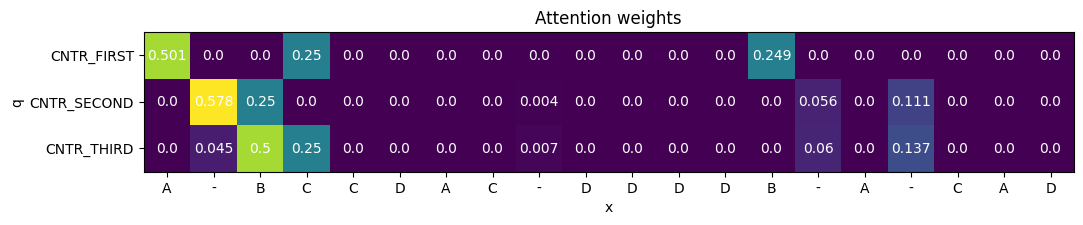

In [ ]:
import matplotlib.colors as colors

attention_weights_numpy = attention_weights.numpy().squeeze()
if len(attention_weights_numpy.shape) < 2:
  attention_weights_numpy = np.expand_dims(attention_weights_numpy, 0)

q_numpy = q.numpy().squeeze()
if len(q_numpy.shape) < 1:
  q_numpy = np.expand_dims(q_numpy, 0)

count_rows = attention_weights_numpy.shape[0]
count_columns = attention_weights_numpy.shape[1]

cell_size = 4
plt.figure(figsize = (cell_size * count_rows, count_columns * cell_size))
plt.imshow(attention_weights_numpy, extent=[0, count_columns, count_rows, 0])

for i in range(count_rows):
  for j in range(count_columns):
    e = attention_weights_numpy[i][j]
    e = np.round(e, 3)
    plt.annotate(str(e), xy=(j+0.5, i+0.5), ha='center', va='center', color='white')

plt.title("Attention weights")
plt.xlabel("x")
plt.ylabel("q")
plt.xticks(
    ticks=np.arange(0, count_columns) + 0.5,
    labels=str_seq(seq)
)
plt.yticks(
    ticks=np.arange(0, count_rows) + 0.5,
    labels=[id_to_query[id] for id in q_numpy]
)

plt.show()